In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import os

import redpandda
from redpandda import *

import resicon
from resicon import *

import geostas
import mdtraj

import MDAnalysis as mda 

import visualizations
import comodo
import hdbscan
import time



In [2]:
from redpandda import preprocessing, preprocess_protein_trajectory
import redpandda_general
from clustering_functions import clustering_workflow
from compare_clusterings import *
import clustering_functions
from timestep_clustering import *

In [3]:
#md_trajectory_info = ['trajectory-1.xtc','fs-peptide.pdb','McGibbon/',10000,4,'mcgib_traj1_geostas_4k.csv','Ace']
md_trajectory_info = ['trajectory-1.xtc','fs-peptide.pdb','McGibbon/',None,None,'mcgib_traj1_geostas_4k.csv','Ace']
trajectory_nr = 1

#how many frames to process
frames_count = md_trajectory_info[3]

In [4]:

trajectory_file = md_trajectory_info[0].split()[0]
pdb_file = md_trajectory_info[1].split()[0]

In [5]:
save_filename = trajectory_file + "_" + pdb_file + ".pickle"
save_filename_csv = trajectory_file + "_" + pdb_file + ".csv"

In [6]:
# call MD-related preprocessing
traj_array, k_cluster = preprocess_protein_trajectory(md_trajectory_info)

In [7]:
clustering_names = []
clustering_results = []

In [8]:
matrices_to_apply = ["delta",  "delta+1std", "delta+2std", "stddv"]
clusterings_to_apply = [
    {
        "name": "Spectral",
        "method": "spectral",
        "params": {"cluster_count": k_cluster}
    },
        {
        "name": "HDBSCAN",
        "method": "hdbscan",
        "params": {}
    },
        {
        "name": "Affinity",
        "method": "affinity",
        "params": {}
    }
]


In [9]:
clusterings_to_apply

[{'name': 'Spectral', 'method': 'spectral', 'params': {'cluster_count': 4}},
 {'name': 'HDBSCAN', 'method': 'hdbscan', 'params': {}},
 {'name': 'Affinity', 'method': 'affinity', 'params': {}}]

In [10]:
res = clustering_workflow(traj_array, matrices_to_apply, clusterings_to_apply, post_process_noise= True)

0.0139
0.0025
0.0030
0.0026
0.0013
0.0019
0.0025
0.0014
0.0036
0.0034
0.0027
0.0021


In [11]:
res

[{'name': 'Spectral',
  'method': 'spectral',
  'params': {'cluster_count': 4},
  'matrix': 'delta',
  'clustering': array([2, 2, 2, 2, 3, 3, 3, 3, 3, 3, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1]),
  'runtime': 0.028148889541625977},
 {'name': 'HDBSCAN',
  'method': 'hdbscan',
  'params': {},
  'matrix': 'delta',
  'clustering': array([0, 0, 0, 1, 1, 2, 2, 2, 2, 2, 2, 3, 3, 3, 3, 4, 4, 4, 4, 4, 4]),
  'runtime': 0.016717195510864258},
 {'name': 'Affinity',
  'method': 'affinity',
  'params': {},
  'matrix': 'delta',
  'clustering': array([0, 0, 0, 1, 1, 1, 2, 2, 2, 3, 3, 3, 4, 4, 4, 5, 5, 5, 6, 6, 6]),
  'runtime': 0.01710963249206543},
 {'name': 'Spectral',
  'method': 'spectral',
  'params': {'cluster_count': 4},
  'matrix': 'stddv',
  'clustering': array([1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 3, 3, 3, 3, 0, 0, 0, 0, 2, 2, 2]),
  'runtime': 0.009944438934326172},
 {'name': 'HDBSCAN',
  'method': 'hdbscan',
  'params': {},
  'matrix': 'stddv',
  'clustering': array([0, 0, 0, 3, 3, 4, 4, 4, 4, 4, 4, 4,

In [12]:
# create matrices for plotting
dist_matrices = redpandda_general.get_distance_matrices(traj_array)
delta_matrices = redpandda_general.get_delta_matrices(dist_matrices)
delta_matrices_wo_absolute = redpandda_general.get_delta_matrices_wo_absolute(dist_matrices)


average_delta_matrix = redpandda_general.calculate_average_delta_matrix(delta_matrices)
average_delta_matrix_wo_absolute = redpandda_general.calculate_average_delta_matrix(delta_matrices_wo_absolute)

average_distance_matrix = redpandda_general.calculate_average_delta_matrix(dist_matrices)

std_distance_matrix = redpandda_general.get_std_matrices(dist_matrices)
std_delta_matrix = redpandda_general.get_std_matrices(delta_matrices)

stddv_matrices = redpandda_general.get_stddv(dist_matrices)


summed_delta_matrix_1std = average_delta_matrix + std_delta_matrix 
summed_delta_matrix_2std = average_delta_matrix + std_delta_matrix * 2

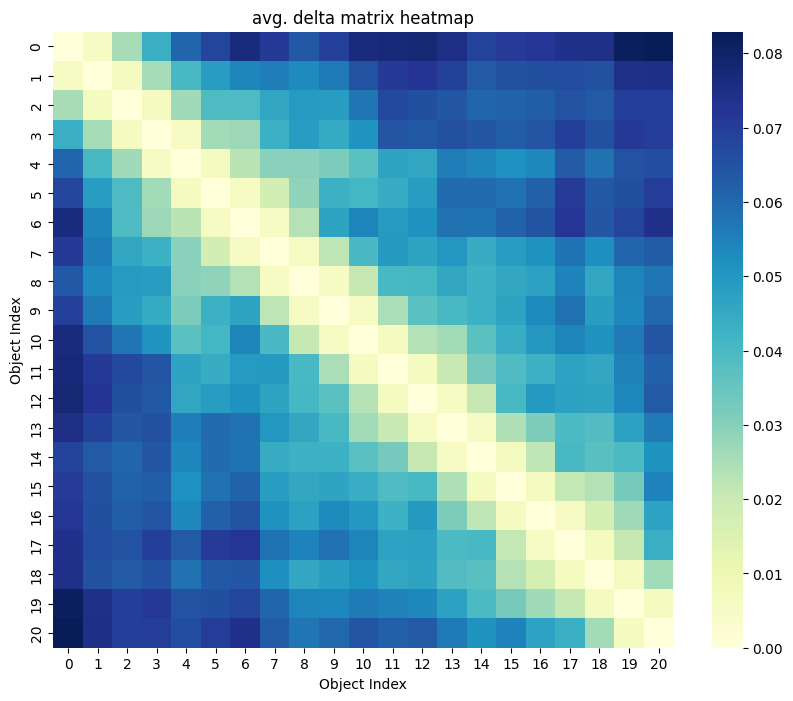

In [13]:
dm.create_delta_heatmap(average_delta_matrix)

In [14]:
for clustering in res:
    curr_clustering = clustering["clustering"]
    Q, _ = cc.get_Q_for_clustering(dist_matrices, curr_clustering, k_cluster)
    clustering["Q"] = Q

## Q values for all clustering methods (lower means better)

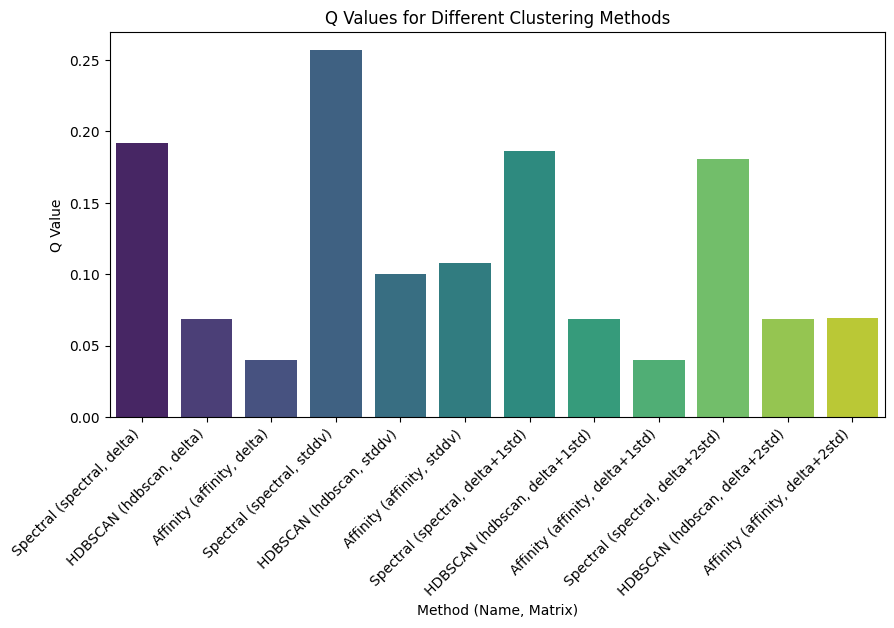

In [15]:
import seaborn as sns
labels = [f"{entry['name']} ({entry['method']}, {entry['matrix']})" for entry in res]
Q_values = [entry['Q'] for entry in res]

# Plot
plt.figure(figsize=(10, 5))
sns.barplot(x=labels, y=Q_values, palette="viridis")

# Labels and title
plt.xlabel("Method (Name, Matrix)")
plt.ylabel("Q Value")
plt.title("Q Values for Different Clustering Methods")
plt.xticks(rotation=45, ha='right')

# Show plot
plt.show()

In [16]:
##### example for postprocessing - is already done in function called above

In [17]:

clustering_hdbscan = res[1]["clustering"]
if -1 in clustering_hdbscan:
    from postprocess_clusterings import assign_noise_points
    final_clustering_hdbscan = assign_noise_points(distance_matrix=delta_matrices, cluster_labels=clustering_hdbscan)

### Visualization of clusterings for each residue
#### clusters are coloured in such a way that the overlap is maximized to facilitate comparison

[array([2, 2, 2, 2, 3, 3, 3, 3, 3, 3, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1]), array([0, 0, 0, 1, 1, 2, 2, 2, 2, 2, 2, 3, 3, 3, 3, 4, 4, 4, 4, 4, 4]), array([0, 0, 0, 1, 1, 1, 2, 2, 2, 3, 3, 3, 4, 4, 4, 5, 5, 5, 6, 6, 6]), array([1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 3, 3, 3, 3, 0, 0, 0, 0, 2, 2, 2]), array([0, 0, 0, 3, 3, 4, 4, 4, 4, 4, 4, 4, 2, 2, 2, 1, 1, 1, 1, 1, 1]), array([0, 0, 0, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 3, 3, 3, 3, 4, 4, 4]), array([2, 2, 2, 2, 0, 0, 0, 0, 0, 3, 3, 3, 3, 3, 3, 1, 1, 1, 1, 1, 1]), array([0, 0, 0, 1, 1, 2, 2, 2, 2, 2, 2, 3, 3, 3, 3, 4, 4, 4, 4, 4, 4]), array([0, 0, 0, 1, 1, 1, 2, 2, 2, 3, 3, 3, 4, 4, 4, 5, 5, 5, 6, 6, 6]), array([2, 2, 2, 2, 1, 1, 1, 1, 1, 1, 3, 3, 3, 3, 3, 0, 0, 0, 0, 0, 0]), array([0, 0, 0, 1, 1, 2, 2, 2, 2, 2, 2, 3, 3, 3, 3, 4, 4, 4, 4, 4, 4]), array([0, 0, 0, 1, 1, 1, 1, 2, 2, 2, 3, 3, 3, 3, 4, 4, 4, 4, 5, 5, 5])]
([2, 2, 2, 2, 3, 3, 3, 3, 3, 3, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1], [2, 2, 2, 1, 1, 3, 3, 3, 3, 3, 3, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1])
([2,

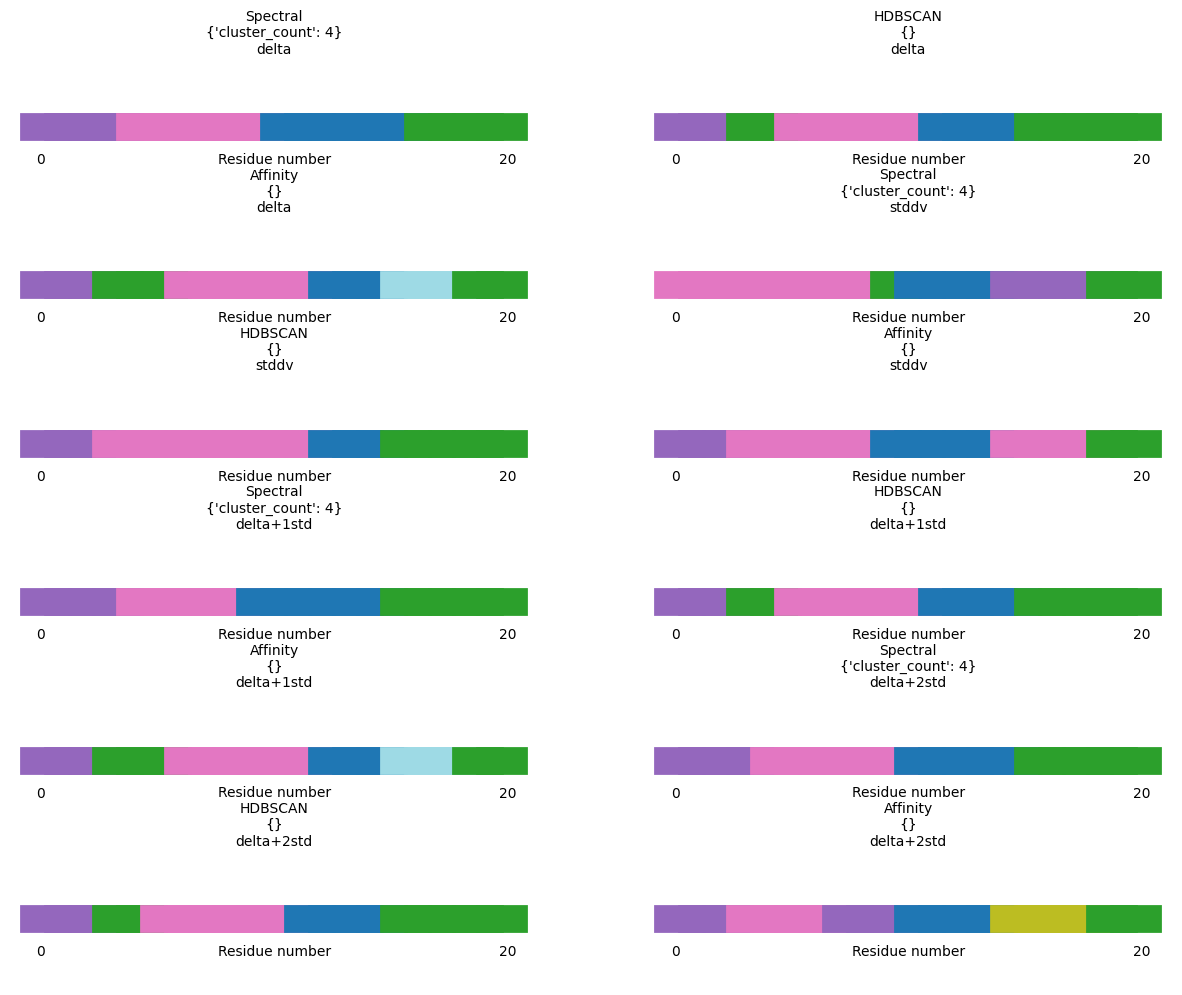

In [18]:
visualizations.line_plot_workflow([item["clustering"] for item in res], titles = [str(item["name"]  + "\n" + str(item["params"]) + "\n" + item["matrix"]) for item in res], full_title = "FS-peptide", rearrange = True, hdb_scan_noise=True, num_cols=2)

# Additional methods - Resicon

In [19]:
resi_dict = dict()


start_time = time.time()

resi_clustering = resicon(md_trajectory_info[0],md_trajectory_info[1],md_trajectory_info[2],k_cluster, only_CA=True)
curr_time = time.time() - start_time 
resi_dict["runtime"] = curr_time

resi_dict["name"] = "Resicon"
resi_dict["method"] = "Resicon"
resi_dict["params"] = ""
resi_dict["clustering"] = np.array(resi_clustering)

Q, _ = cc.get_Q_for_clustering(dist_matrices, resi_dict["clustering"], k=len(np.unique(resi_clustering)))
resi_dict["Q"] = Q
res.append(resi_dict)



0.2854
Resicon residue:
ALA
0
Resicon residue:
ALA
1
Resicon residue:
ALA
2
Resicon residue:
ALA
3
Resicon residue:
ALA
4
Resicon residue:
ALA
5
Resicon residue:
ALA
6
Resicon residue:
ALA
7
Resicon residue:
ARG
8
Resicon residue:
ALA
9
Resicon residue:
ALA
10
Resicon residue:
ALA
11
Resicon residue:
ALA
12
Resicon residue:
ARG
13
Resicon residue:
ALA
14
Resicon residue:
ALA
15
Resicon residue:
ALA
16
Resicon residue:
ALA
17
Resicon residue:
ARG
18
Resicon residue:
ALA
19
Resicon residue:
ALA
20
32.7696


# Additional methods - Comodo

In [20]:
import visualizations
import comodo

In [21]:
md_trajectory_info[0]

'trajectory-1.xtc'

In [22]:
md_trajectory_info_dcd = md_trajectory_info.copy()

In [23]:
md_trajectory_info_dcd[0] = "trajectory-1.dcd"

In [24]:
comodo_dict = dict()

start_time = time.time()

com_pd_eln = comodo.full_comodo_clustering(os.path.join("trajdata","McGibbon","trajectory-1.pdb"), elastic_network=True)
curr_time = time.time() - start_time 
comodo_dict["runtime"] = curr_time


comodo_dict["name"] = "Comodo"
comodo_dict["method"] = "Comodo"
comodo_dict["params"] = "Elastic Network"
comodo_dict["clustering"] = np.array(com_pd_eln)
Q, _ = cc.get_Q_for_clustering(dist_matrices, comodo_dict["clustering"], k=len(np.unique(com_pd_eln)))
comodo_dict["Q"] = Q
res.append(comodo_dict)

Name of cov-file: ftrajdata/McGibbon/trajectory-1.cov


R[write to console]: In addition: 
R[write to console]: Warning messages:

R[write to console]: 1: 
R[write to console]: In (function (package, help, pos = 2, lib.loc = NULL, character.only = FALSE,  :
R[write to console]: 
 
R[write to console]:  libraries ‘/usr/local/lib/R/site-library’, ‘/usr/lib/R/site-library’ contain no packages

R[write to console]: 2: 
R[write to console]: In (function (package, help, pos = 2, lib.loc = NULL, character.only = FALSE,  :
R[write to console]: 
 
R[write to console]:  libraries ‘/usr/local/lib/R/site-library’, ‘/usr/lib/R/site-library’ contain no packages



Name of output file: trajdata/McGibbon/trajectory-1.cov
{1: [1, 2, 3, 4, 5, 6, 7, 8], 2: [9, 10, 11, 12, 13], 3: [14, 15, 16, 17, 18, 19, 20, 21]}


In [25]:
comodo_dict = dict()

start_time = time.time()
com_pd_no_eln = comodo.full_comodo_clustering(md_trajectory_info_dcd, elastic_network=False)

curr_time = time.time() - start_time 
comodo_dict["runtime"] = curr_time


comodo_dict["name"] = "Comodo"
comodo_dict["method"] = "Comodo"
comodo_dict["params"] = "Full Covariance Matrix"
comodo_dict["clustering"] = np.array(com_pd_no_eln)
Q, _ = cc.get_Q_for_clustering(dist_matrices, comodo_dict["clustering"], k=len(np.unique(com_pd_eln)))
comodo_dict["Q"] = Q
res.append(comodo_dict)

Name of cov-file: ftrajdata/McGibbon/trajectory-1.cov
traj
['trajectory-1.dcd', 'fs-peptide.pdb', 'McGibbon/', None, None, 'mcgib_traj1_geostas_4k.csv', 'Ace']
trajectory-1.dcd
orig. covariance_matrix
[[ 0.96064204  0.76123494  0.540337    0.4601476   0.32321304  0.06073728
  -0.04518713  0.07075676  0.00194527 -0.25245005 -0.249815   -0.16960503
  -0.2588492  -0.17942773 -0.23709829 -0.353607   -0.38429183 -0.39359218
  -0.23552008 -0.1726909  -0.24688175]
 [ 0.76123494  0.7083713   0.5264072   0.4548266   0.30961865  0.05961245
  -0.0441772   0.07544374  0.01920898 -0.23489273 -0.23656851 -0.13618276
  -0.20954892 -0.13073517 -0.19396618 -0.29452178 -0.3369652  -0.3633553
  -0.26151758 -0.20242196 -0.26987842]
 [ 0.540337    0.5264072   0.49076474  0.4620426   0.35691205  0.14785376
   0.04666077  0.1232091   0.07087299 -0.14818631 -0.18417084 -0.12215789
  -0.23895814 -0.1898339  -0.20351923 -0.28540367 -0.29699022 -0.30140892
  -0.25498143 -0.2385959  -0.3008559 ]
 [ 0.4601476   0.

# Additional methods - GeoStas

In [26]:
from geostas import *
geostas_dict = dict()

start_time = time.time()

geostas_clusters = compute_geostas_clusters_multipdb(filename=os.path.join("trajdata", md_trajectory_info_dcd[2], "trajectory-1_multipdb.pdb"), only_CA=True)


curr_time = time.time() - start_time 
geostas_dict["runtime"] = curr_time

geostas_dict["name"] = "Geostas"
geostas_dict["method"] = "Geostas"
geostas_dict["params"] = ""
geostas_dict["clustering"] = np.array(geostas_clusters)
Q, _ = cc.get_Q_for_clustering(dist_matrices, geostas_dict["clustering"], k=len(np.unique(geostas_clusters)))
geostas_dict["Q"] = Q
res.append(geostas_dict)

  .. 21 'calpha' atoms selected
  .. 'xyz' coordinate data with 10000 frames 
  .. 'fit=TRUE': running function 'core.find'
  .. coordinates are superimposed to core region
  .. calculating atomic movement similarity matrix ('amsm.xyz()') 
  .. dimensions of AMSM are 21x21
  .. clustering AMSM using 'kmeans' 
  .. converting indices to match input 'pdb' object 
     (additional attribute 'atomgrps' generated) 


# Save Files

In [27]:
import pickle

with open(save_filename, 'wb') as pickle_file:
    pickle.dump(res, pickle_file)

df = pd.DataFrame(res)
df.to_csv(save_filename_csv, index=False)

In [28]:
df

,name,method,params,matrix,clustering,runtime,Q
0,Spectral,spectral,{'cluster_count': 4},delta,"[2, 2, 2, 2, 3, 3, 3, 3, 3, 3, 0, 0, 0, 0, 0, ...",0.028149,0.192162
1,HDBSCAN,hdbscan,{},delta,"[0, 0, 0, 1, 1, 2, 2, 2, 2, 2, 2, 3, 3, 3, 3, ...",0.016717,0.068465
2,Affinity,affinity,{},delta,"[0, 0, 0, 1, 1, 1, 2, 2, 2, 3, 3, 3, 4, 4, 4, ...",0.017110,0.040095
3,Spectral,spectral,{'cluster_count': 4},stddv,"[1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 3, 3, 3, 3, 0, ...",0.009944,0.256704
4,HDBSCAN,hdbscan,{},stddv,"[0, 0, 0, 3, 3, 4, 4, 4, 4, 4, 4, 4, 2, 2, 2, ...",0.008610,0.099777
5,Affinity,affinity,{},stddv,"[0, 0, 0, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 3, ...",0.009172,0.107852
6,Spectral,spectral,{'cluster_count': 4},delta+1std,"[2, 2, 2, 2, 0, 0, 0, 0, 0, 3, 3, 3, 3, 3, 3, ...",0.016607,0.186375
7,HDBSCAN,hdbscan,{},delta+1std,"[0, 0, 0, 1, 1, 2, 2, 2, 2, 2, 2, 3, 3, 3, 3, ...",0.015569,0.068465
8,Affinity,affinity,{},delta+1std,"[0, 0, 0, 1, 1, 1, 2, 2, 2, 3, 3, 3, 4, 4, 4, ...",0.017786,0.040095
9,Spectral,spectral,{'cluster_count': 4},delta+2std,"[2, 2, 2, 2, 1, 1, 1, 1, 1, 1, 3, 3, 3, 3, 3, ...",0.017602,0.180867


# Distribution visualization

In [29]:
from compare_distributions import dist_heatmaps_for_matrices

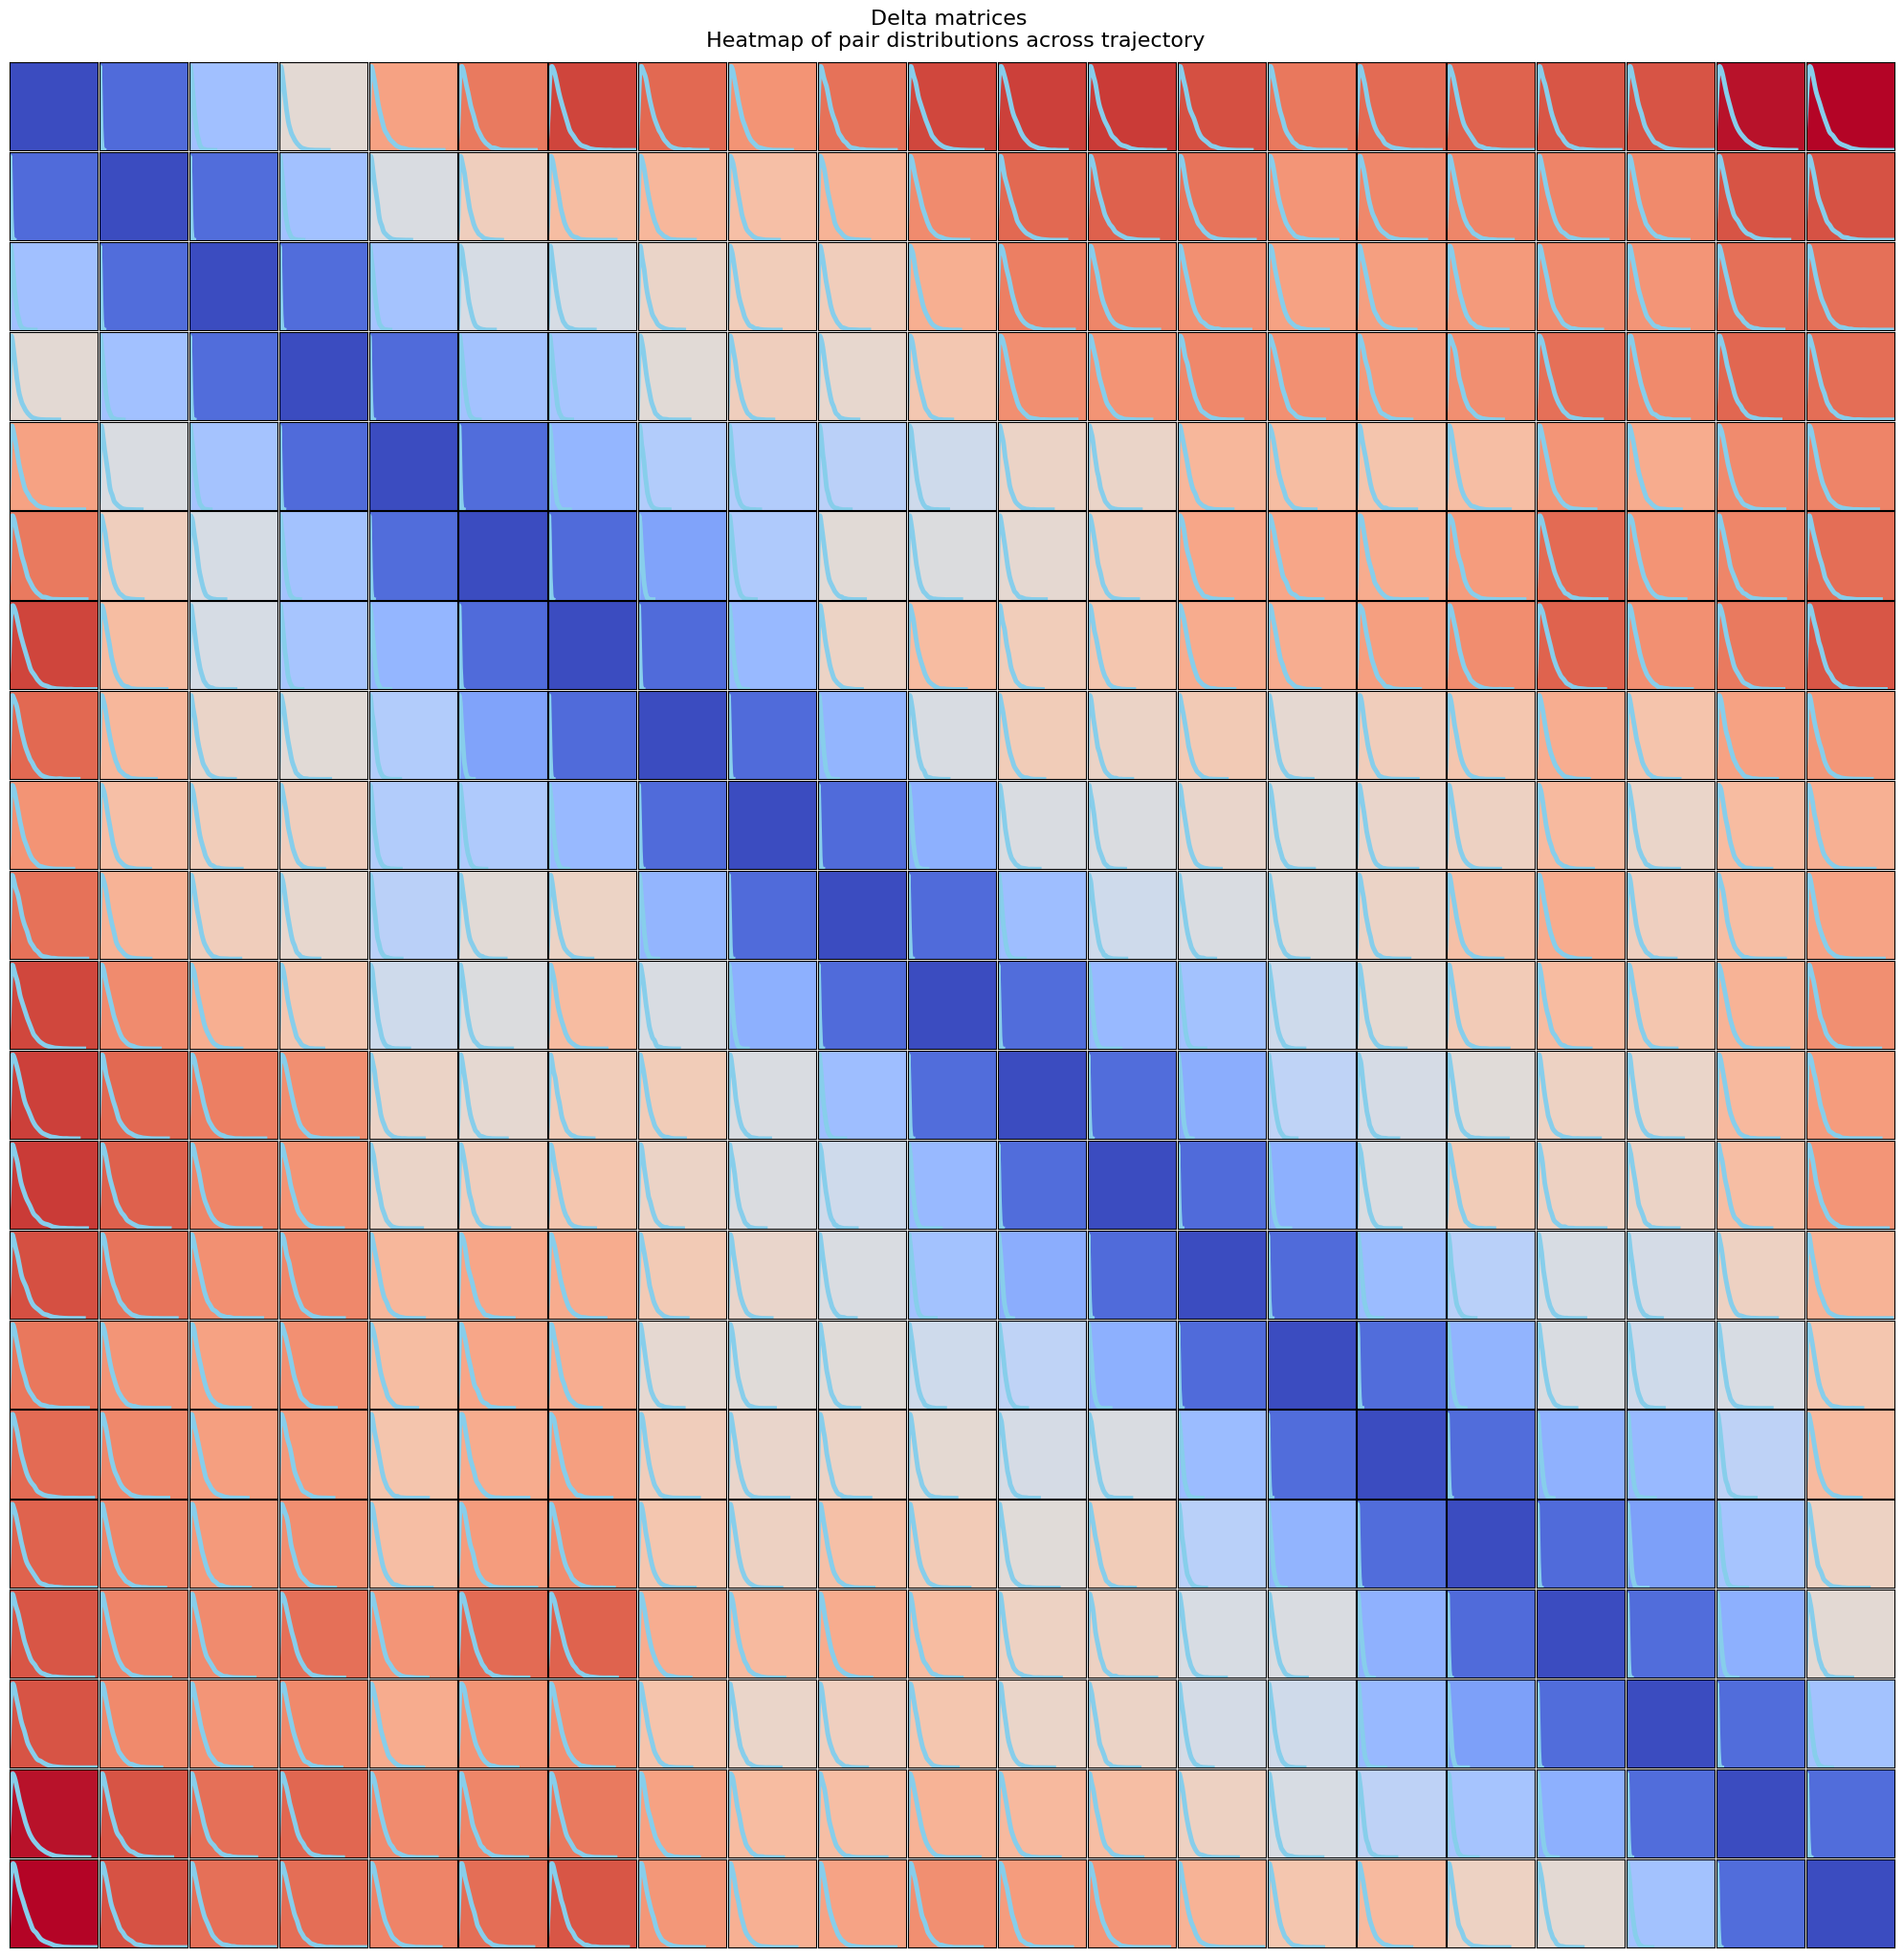

In [30]:
dist_heatmaps_for_matrices(delta_matrices,title="Delta matrices \n Heatmap of pair distributions across trajectory")


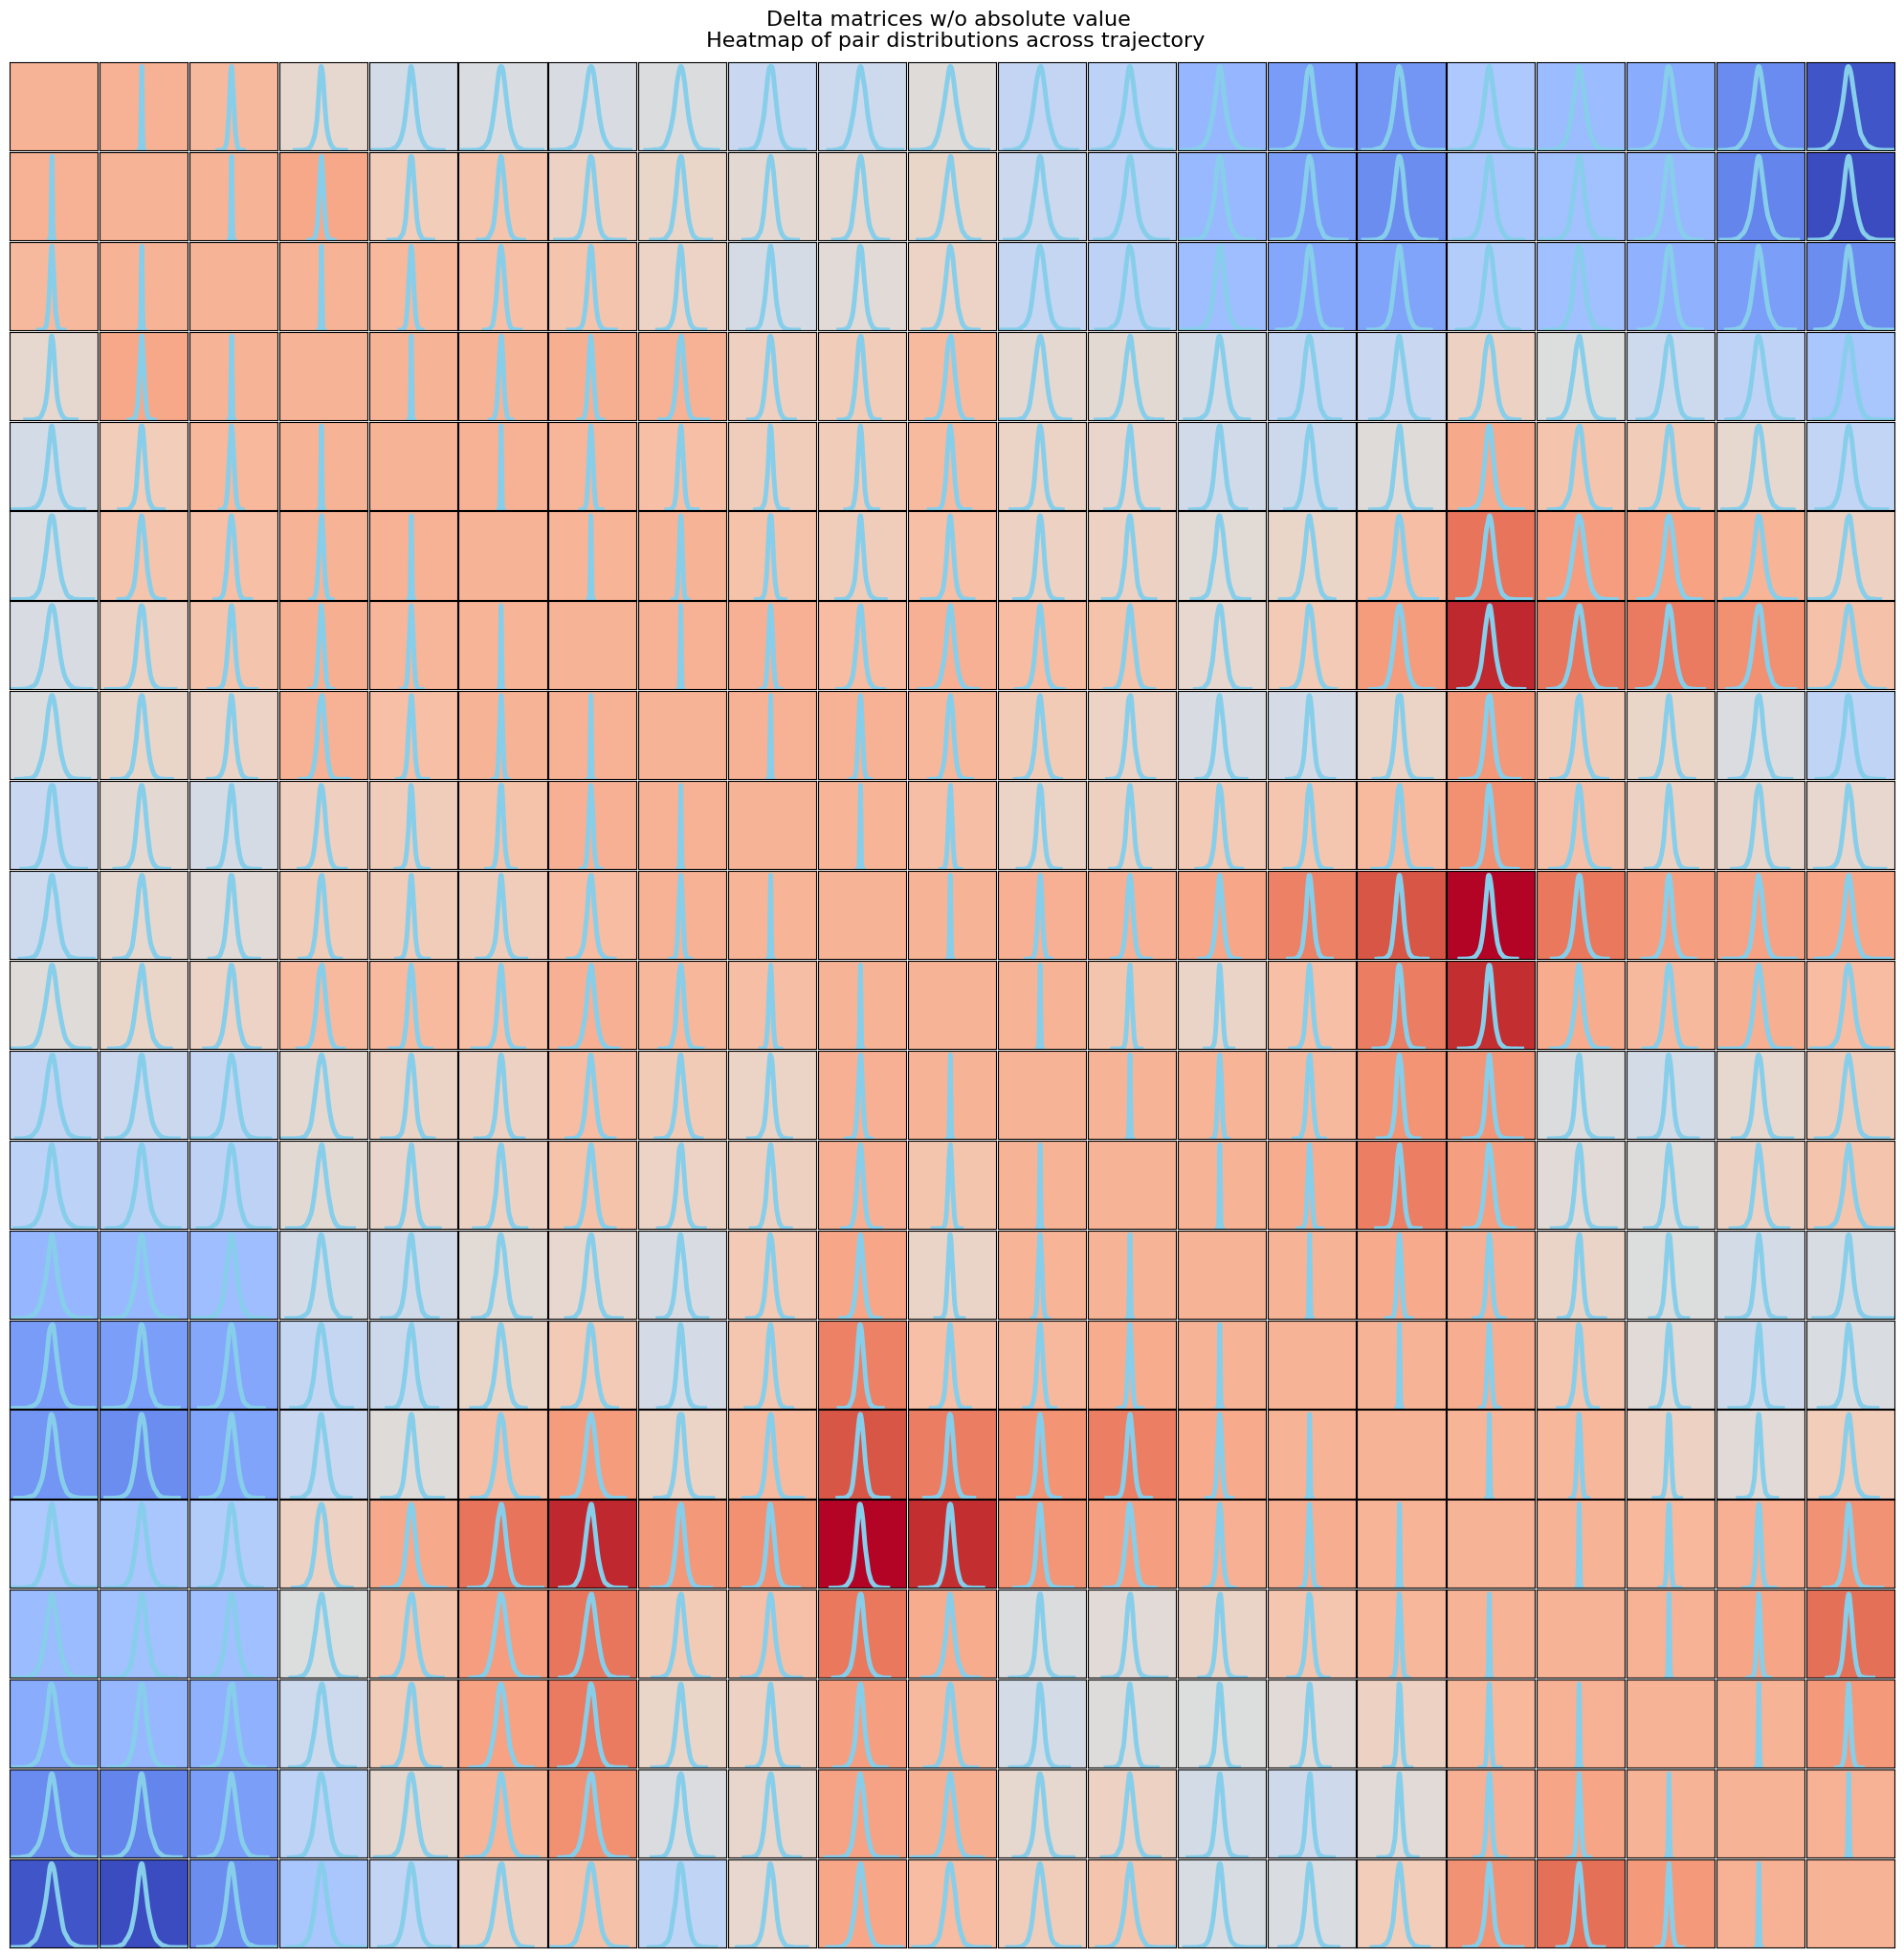

In [31]:
dist_heatmaps_for_matrices(delta_matrices_wo_absolute,title="Delta matrices w/o absolute value \n Heatmap of pair distributions across trajectory")

# Further analyses

Text(0.5, 1.0, 'Q_max from distance matrices, full')

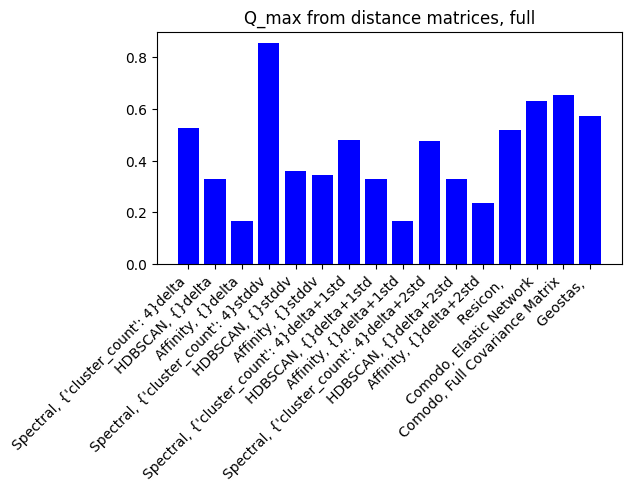

In [32]:
Qs = []
clustering_names = []
from compare_clusterings import *
for i, cl in enumerate([cl["clustering"] for cl in res]):

    new_dist_Q_max_value, _ = get_Q_for_clustering_extended(dist_matrices, np.array(cl), None, use_max=True, thinning_factor=500, only_adjacent=False, reference_frame=None, return_raw=False)
    Qs.append(new_dist_Q_max_value)
    try:
        clustering_names.append(res[i]["name"] + ", " + str(res[i]["params"]) + res[i]["matrix"])
    except:
        clustering_names.append(res[i]["name"] + ", " + str(res[i]["params"]) )

plt.bar(clustering_names, Qs, color='blue')
plt.xticks(rotation=45, ha='right') 

plt.tight_layout()

plt.title("Q_max from distance matrices, full")

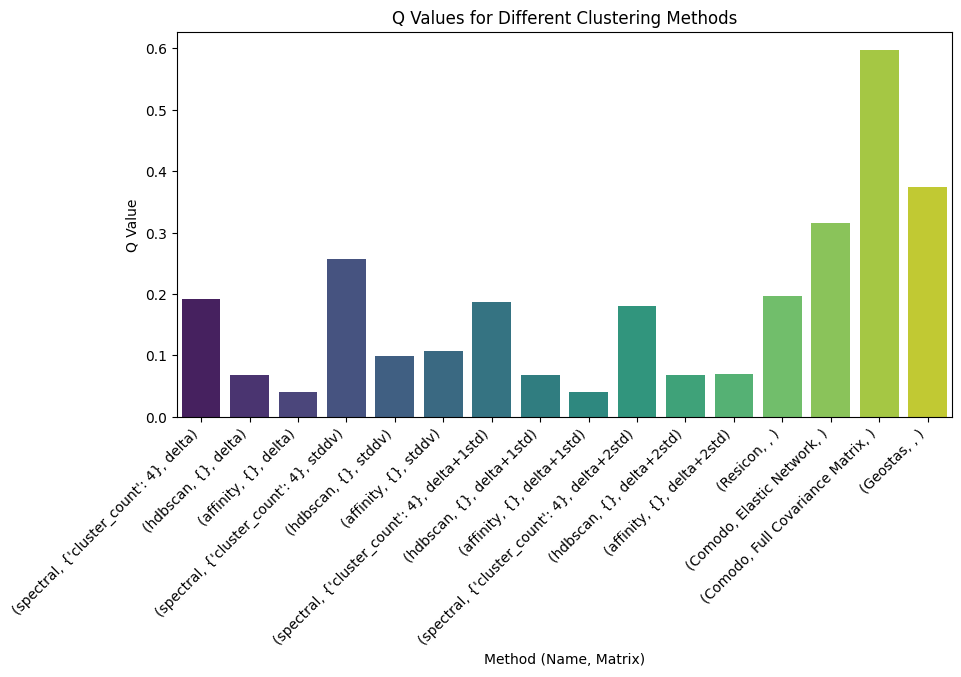

In [33]:
import seaborn as sns
labels = [f"({entry['method']}, {entry['params']}, {entry.get('matrix', '')})" for entry in res]
Q_values = [entry['Q'] for entry in res]

# Plot
plt.figure(figsize=(10, 5))
sns.barplot(x=labels, y=Q_values, palette="viridis")

# Labels and title
plt.xlabel("Method (Name, Matrix)")
plt.ylabel("Q Value")
plt.title("Q Values for Different Clustering Methods")
plt.xticks(rotation=45, ha='right')

# Show plot
plt.show()

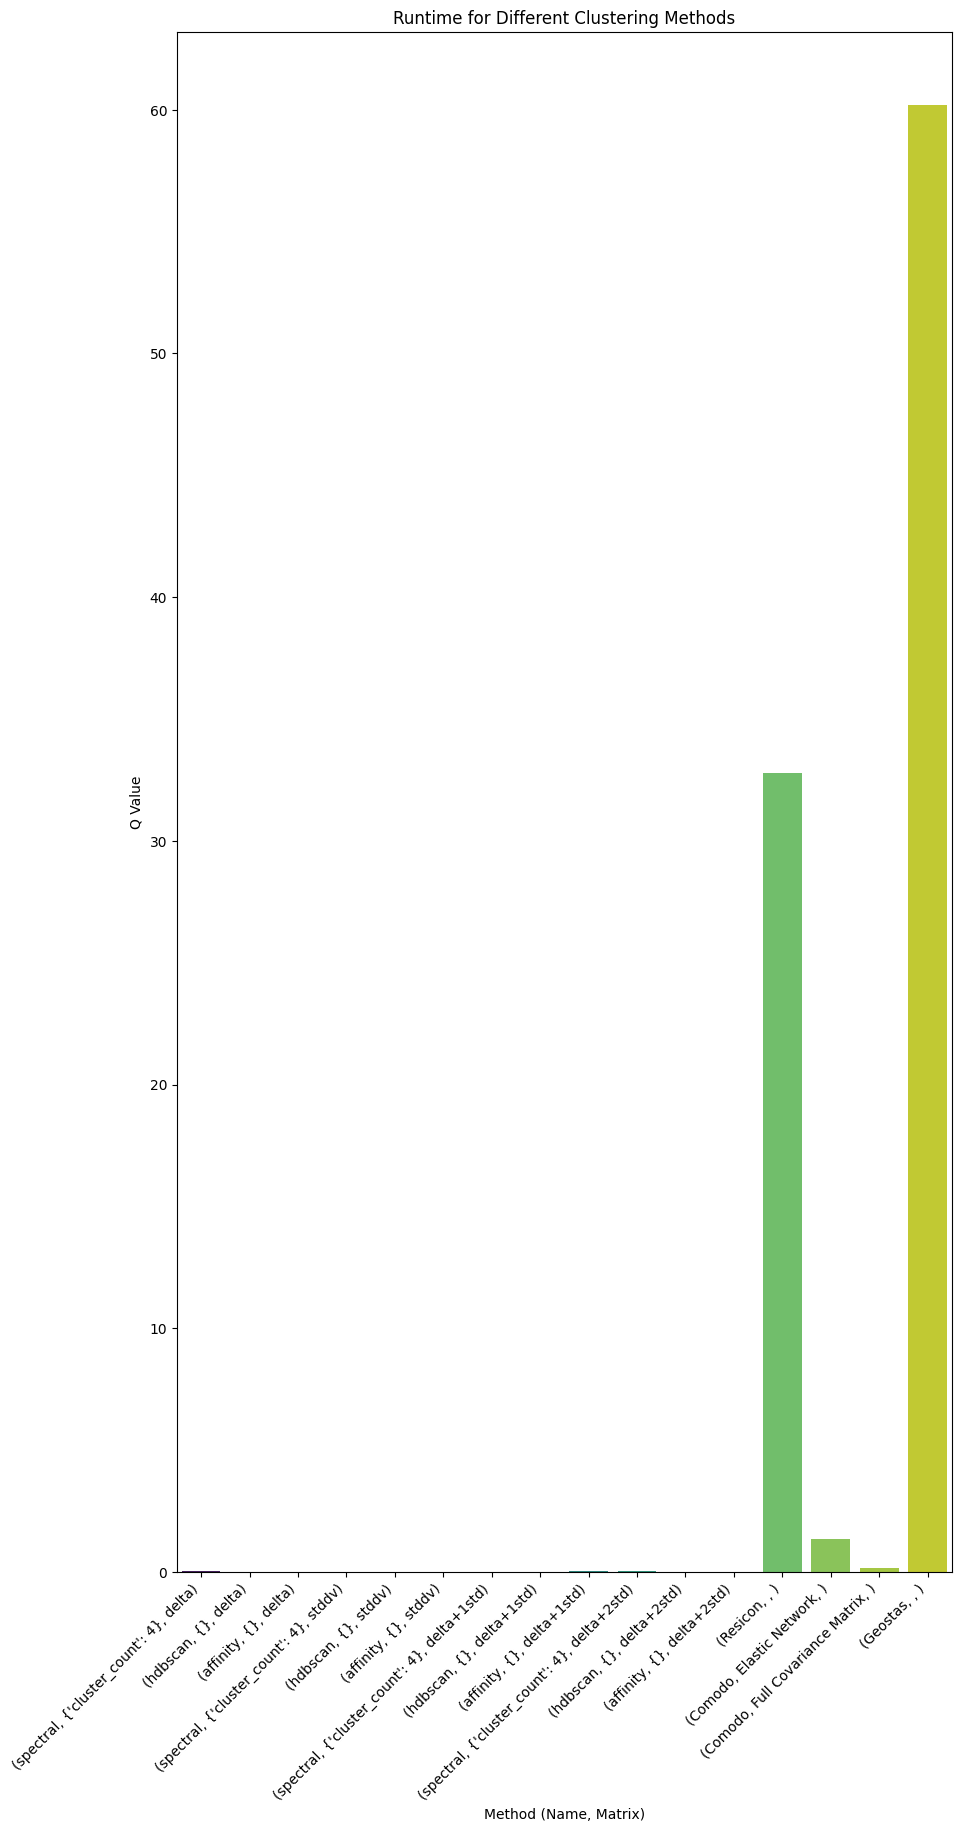

In [34]:
import seaborn as sns
labels = [f"({entry['method']}, {entry['params']}, {entry.get('matrix', '')})" for entry in res]
runtimes = [entry['runtime'] for entry in res]

# Plot
plt.figure(figsize=(10, 20))
sns.barplot(x=labels, y=runtimes, palette="viridis")

# Labels and title
plt.xlabel("Method (Name, Matrix)")
plt.ylabel("Q Value")
plt.title("Runtime for Different Clustering Methods")
plt.xticks(rotation=45, ha='right')

# Show plot
plt.show()

### For the next steps (visualizing of RMSD etc.), we select Spectral Clustering with 4 clusters

In [35]:
spectral_clustering_res = res[0]["clustering"]

In [36]:
from compare_clusterings import *

In [37]:
max_rmse_wo_clustering = get_Q_max_RMSE_wo_clustering(delta_matrices)

In [38]:
spectral_clustering_res

array([2, 2, 2, 2, 3, 3, 3, 3, 3, 3, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1])

In [39]:
max_rmse_for_clustering = get_Q_max_RMSE_for_clustering(delta_matrices, spectral_clustering_res, len(np.unique(spectral_clustering_res)))

In [40]:
pdb_trajectory_info = ['fs-peptide.pdb','fs-peptide.pdb','McGibbon/',None,None,'mcgib_traj1_geostas_4k.csv','Ace']
traj_array_pdb, k_cluster_pdb = preprocess_protein_trajectory(pdb_trajectory_info)

# For this protein we have an additional pdb-file: We can take this as reference

In [41]:
pdb_dist = redpandda_general.get_distance_matrices(traj_array_pdb)

In [42]:
get_total_rmses_for_frames, cluster_rmses, clusters_mean_rmses = get_RMSE_of_clusters_and_total(pdb_dist, dist_matrices,spectral_clustering_res, len(np.unique(spectral_clustering_res)))

# Plotting of the average RMSE of COMET clusters against the RMSE without clustering

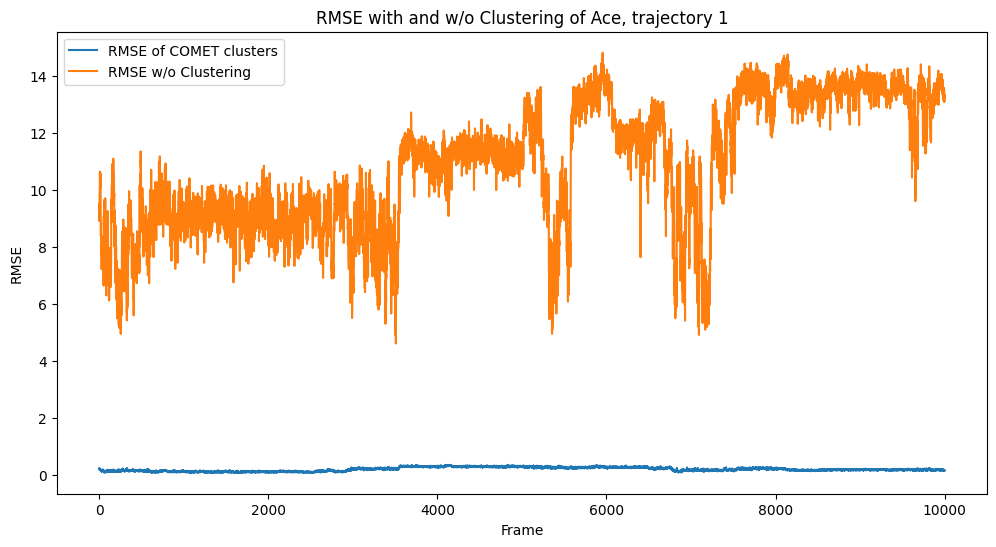

In [43]:
plt.figure(figsize=(12, 6))
plt.plot(clusters_mean_rmses, label="RMSE of COMET clusters")
plt.plot(get_total_rmses_for_frames, label="RMSE w/o Clustering")

plt.xlabel('Frame')  
plt.ylabel('RMSE')  

plt.title('RMSE with and w/o Clustering of Ace, trajectory ' + str(trajectory_nr)) 

plt.legend()

plt.show()

# Plotting of the RMSE of all COMET clusters against the RMSE without clustering

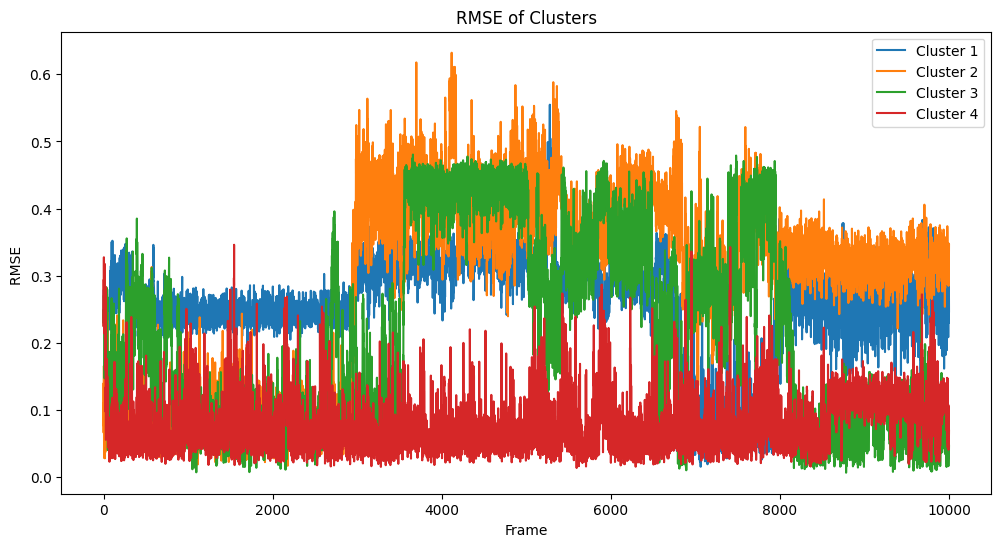

In [44]:
plt.figure(figsize=(12, 6))
for i, cluster_rmse in enumerate(cluster_rmses):    
    plt.plot(cluster_rmse, label=f'Cluster {i+1}')

plt.xlabel('Frame')  
plt.ylabel('RMSE ')  

plt.title('RMSE of Clusters') 

plt.legend()

plt.show()

### Furthermore, we can compute the sum of all delta matrices and compare this to the RMSE.

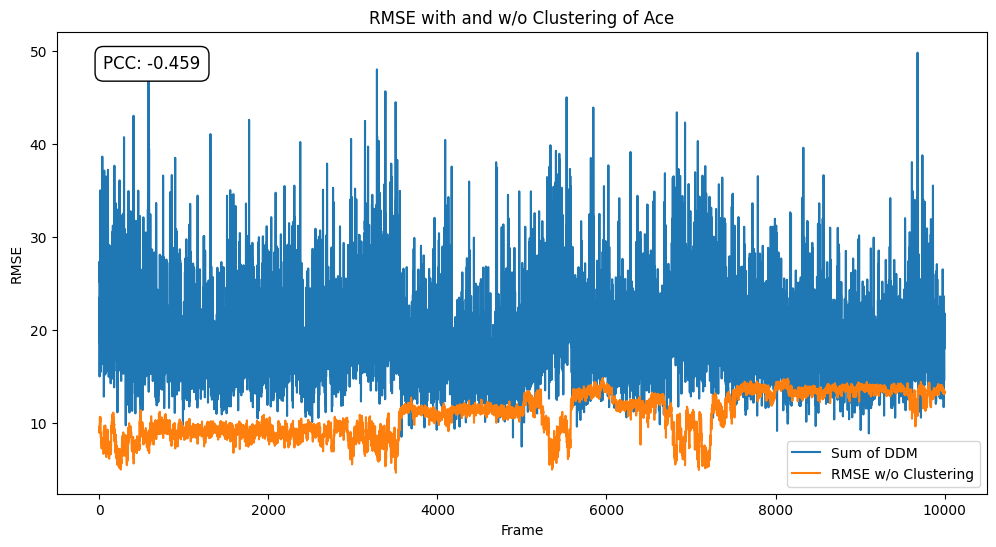

In [45]:
summed_delta_matrices= []
for delta_matrix in delta_matrices:
    summed_delta_matrices.append(dm.sum_up_matrices(delta_matrix.flatten()))

batched_summed_delta_matrices, batched_get_total_rmses_for_frames = get_sdm_batches(summed_delta_matrices,get_total_rmses_for_frames)
import scipy
pcc = scipy.stats.pearsonr(batched_summed_delta_matrices,batched_get_total_rmses_for_frames )[0]


plt.figure(figsize=(12, 6))
plt.plot(summed_delta_matrices, label="Sum of DDM")
plt.plot(get_total_rmses_for_frames, label="RMSE w/o Clustering")

plt.xlabel('Frame')  
plt.ylabel('RMSE')  

plt.title('RMSE with and w/o Clustering of Ace') 


plt.text(
    0.05,  # x-position (percentage of the x-axis range)
    0.95,  # y-position (percentage of the y-axis range)
    f'PCC: {pcc:.3f}',  # Text to display with 3 decimal places
    transform=plt.gca().transAxes,  # Use axis coordinate system (0-1 range)
    fontsize=12,  # Font size of the text
    verticalalignment='top',  # Position the text at the top
    horizontalalignment='left',  # Position the text on the left side
    bbox=dict(facecolor='white', edgecolor='black', boxstyle='round,pad=0.5')  # Box around the text for clarity
)

plt.legend()

plt.show()

##### Only relabeling of the clustering labels array - because code excepts to start clusterings with 0

In [46]:
relabeled_array = relabel_clustering_starting_from_zero(spectral_clustering_res)

### Finally, we can plot the RMSD of clusters against a reference frame of the trajectory (for this frame, the RMSD is, of course, 0) or against the average structure (in case no reference_frame-parameter is passed)

In [47]:
Q_from_pos_trajectory_average = get_RMSD_to_reference(traj_array, relabeled_array, apply_superimposition=None, return_raw=True)
Q_from_pos_trajectory_reference_frame = get_RMSD_to_reference(traj_array, relabeled_array, apply_superimposition=None, reference_frame=0, return_raw=True)
Q_from_pos_trajectory_reference_frame_1000 = get_RMSD_to_reference(traj_array, relabeled_array, apply_superimposition=None, reference_frame=1000, return_raw=True)


Q_from_pos_trajectory_average_kabsch = get_RMSD_to_reference(traj_array, relabeled_array, apply_superimposition="Kabsch",  return_raw=True)
Q_from_pos_trajectory_reference_frame_kabsch = get_RMSD_to_reference(traj_array, relabeled_array, apply_superimposition="Kabsch", reference_frame=0, return_raw=True)
Q_from_pos_trajectory_reference_frame_1000_kabsch = get_RMSD_to_reference(traj_array, relabeled_array, apply_superimposition="Kabsch", reference_frame=1000, return_raw=True)


Q_from_pos_trajectory_average_procrustes = get_RMSD_to_reference(traj_array, relabeled_array, apply_superimposition="procrustes",  return_raw=True)
Q_from_pos_trajectory_reference_frame_procrustes = get_RMSD_to_reference(traj_array, relabeled_array, apply_superimposition="procrustes", reference_frame=0, return_raw=True)
Q_from_pos_trajectory_reference_frame_1000_procrustes = get_RMSD_to_reference(traj_array, relabeled_array, apply_superimposition="procrustes", reference_frame=1000, return_raw=True)

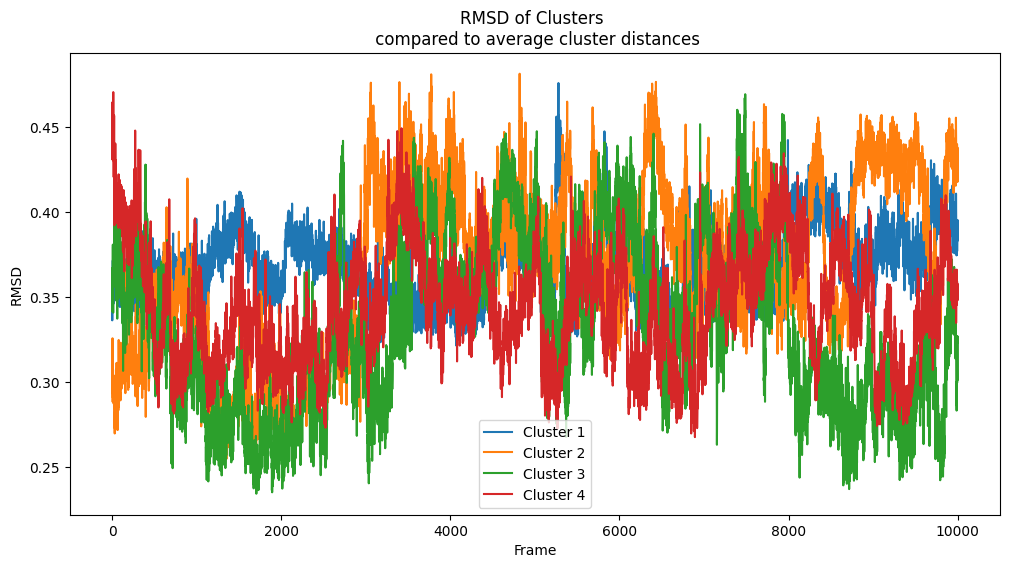

In [48]:
plt.figure(figsize=(12, 6))
for i, cluster_q in enumerate(Q_from_pos_trajectory_average):    
    plt.plot(cluster_q, label=f'Cluster {i+1}')

plt.xlabel('Frame')  
plt.ylabel('RMSD')  

plt.title('RMSD of Clusters \n compared to average cluster distances') 

plt.legend()

plt.show()

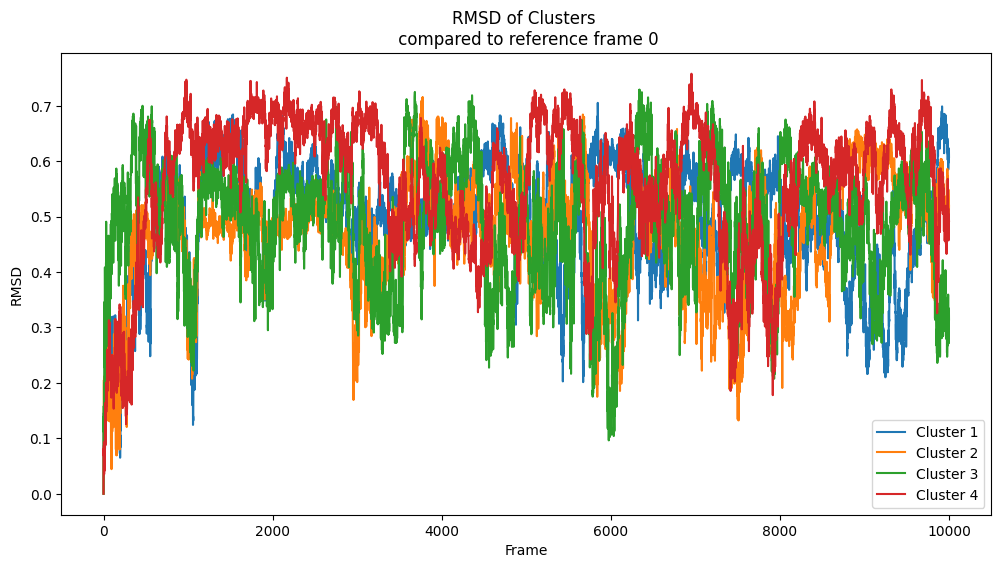

In [49]:
plt.figure(figsize=(12, 6))
for i, cluster_q in enumerate(Q_from_pos_trajectory_reference_frame):    
    plt.plot(cluster_q, label=f'Cluster {i+1}')

plt.xlabel('Frame')  
plt.ylabel('RMSD')  

plt.title('RMSD of Clusters \n compared to reference frame 0') 

plt.legend()

plt.show()

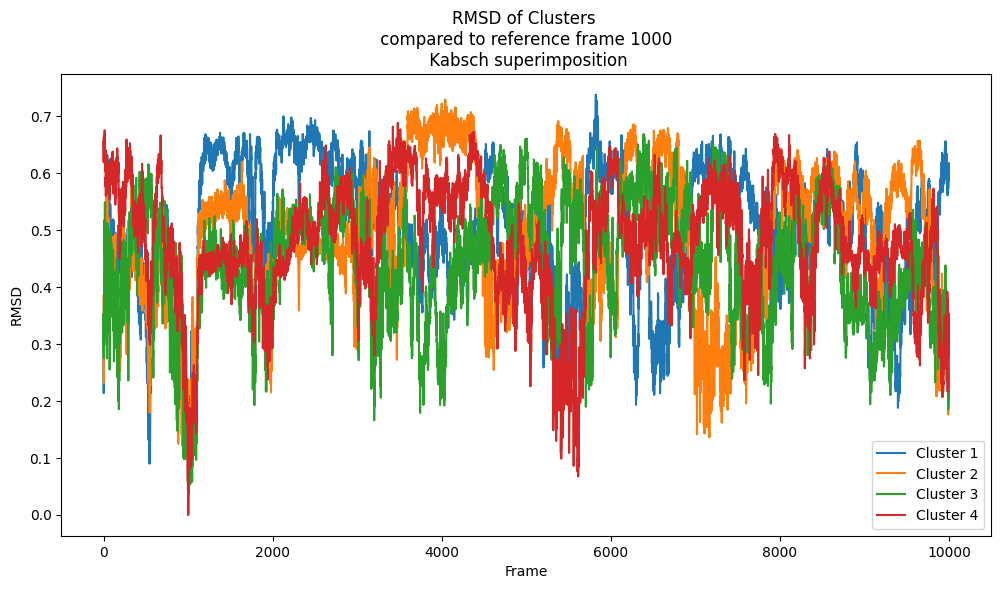

In [50]:
plt.figure(figsize=(12, 6))
for i, cluster_q in enumerate(Q_from_pos_trajectory_reference_frame_1000_kabsch):    
    plt.plot(cluster_q, label=f'Cluster {i+1}')

plt.xlabel('Frame')  
plt.ylabel('RMSD')  

plt.title('RMSD of Clusters \n compared to reference frame 1000 \n Kabsch superimposition') 

plt.legend()

plt.show()

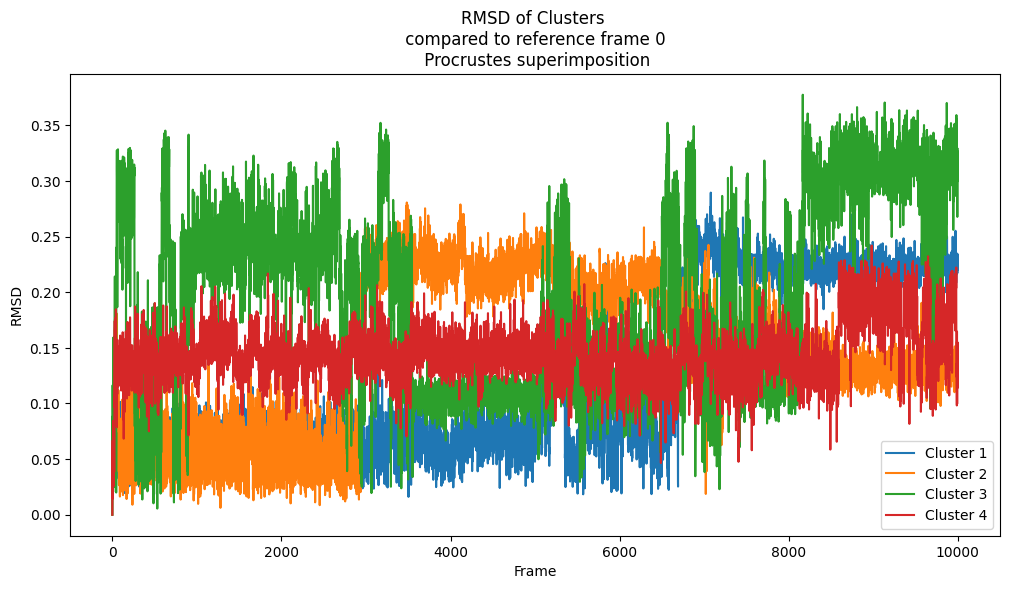

In [51]:
plt.figure(figsize=(12, 6))
for i, cluster_q in enumerate(Q_from_pos_trajectory_reference_frame_procrustes):    
    plt.plot(cluster_q, label=f'Cluster {i+1}')

plt.xlabel('Frame')  
plt.ylabel('RMSD')  

plt.title('RMSD of Clusters \n compared to reference frame 0 \n Procrustes superimposition') 

plt.legend()

plt.show()

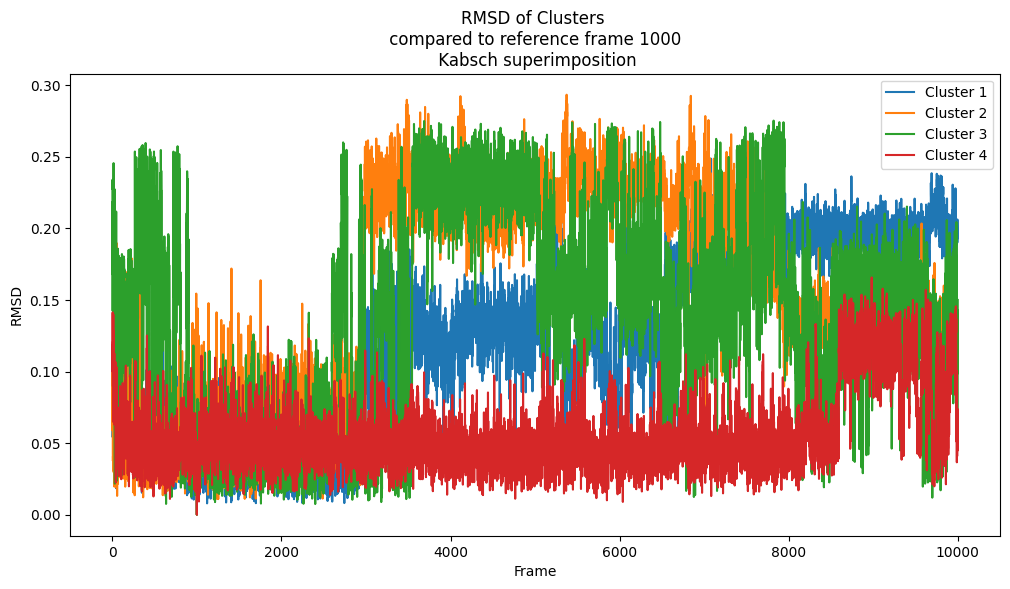

In [52]:
plt.figure(figsize=(12, 6))
for i, cluster_q in enumerate(Q_from_pos_trajectory_reference_frame_1000_procrustes):    
    plt.plot(cluster_q, label=f'Cluster {i+1}')

plt.xlabel('Frame')  
plt.ylabel('RMSD')  

plt.title('RMSD of Clusters \n compared to reference frame 1000 \n Kabsch superimposition') 

plt.legend()

plt.show()

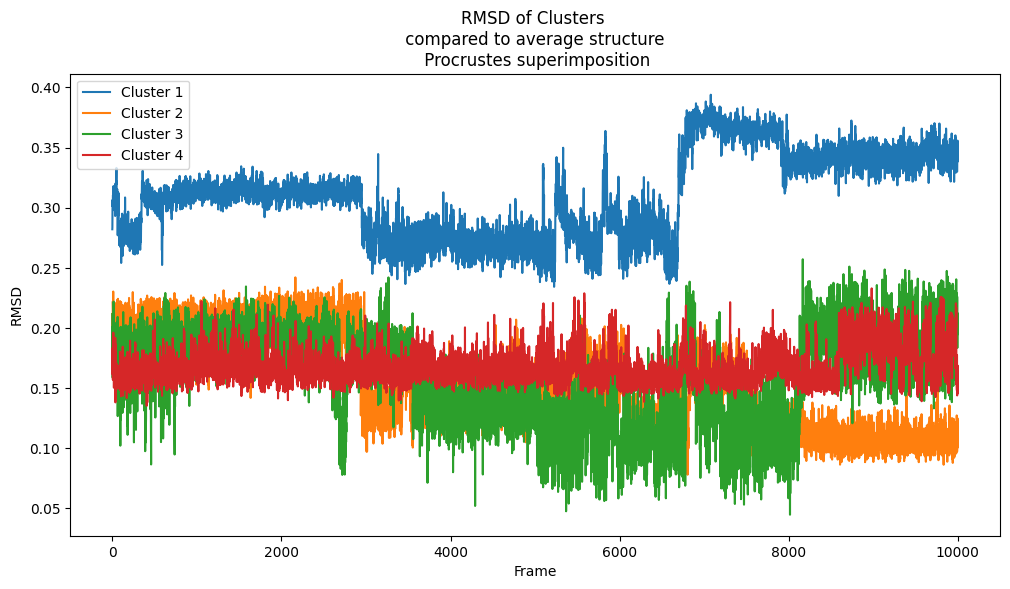

In [53]:
plt.figure(figsize=(12, 6))
for i, cluster_q in enumerate(Q_from_pos_trajectory_average_procrustes):    
    plt.plot(cluster_q, label=f'Cluster {i+1}')

plt.xlabel('Frame')  
plt.ylabel('RMSD')  

plt.title('RMSD of Clusters \n compared to average structure \n Procrustes superimposition') 

plt.legend()

plt.show()

## Finally, we can refine the result by iterative clustering of time segments. We get the time segments from detecting changes in the Q-values of the clusters (as plotted above). For each time segment, we repeat the clustering. For the small protein, the clusterings are very similar for each time segment, but for trajectories with major changes, the clusterings will be highly different. To obtain consistent clusters, we apply the Munkres-algorithm: The clustering labels are reorded in such a way that the overlap is maximized.

0.0047
0.0030
0.0042
0.0034
0.0028
0.0053
0.0027
0.0044
0.0027
clustering for timestep 0 - 738: [1 1 1 2 2 2 2 2 2 0 0 0 0 0 0 0 3 3 3 3 3]
clustering for timestep 739 - 1674: [1 1 1 1 2 2 2 2 2 2 0 0 0 0 0 3 3 3 3 3 3]
clustering for timestep 1675 - 2500: [1 1 1 1 2 2 2 2 2 2 0 0 0 0 0 0 3 3 3 3 3]
clustering for timestep 2501 - 3245: [1 1 1 1 2 2 2 2 2 2 2 0 0 0 0 0 3 3 3 3 3]
clustering for timestep 3246 - 4380: [1 1 1 1 2 2 2 2 2 2 2 0 0 0 0 0 0 3 3 3 3]
clustering for timestep 4381 - 5000: [1 1 1 1 1 2 2 2 2 2 2 2 0 0 0 0 0 3 3 3 3]
clustering for timestep 5001 - 5889: [1 1 1 2 2 2 2 2 2 0 0 0 0 0 0 0 3 3 3 3 3]
clustering for timestep 5890 - 7032: [1 1 1 1 2 2 2 2 2 2 0 0 0 0 0 3 3 3 3 3 3]
clustering for timestep 7033 - 10000: [1 1 1 1 2 2 2 2 2 0 0 0 0 0 0 3 3 3 3 3 3]


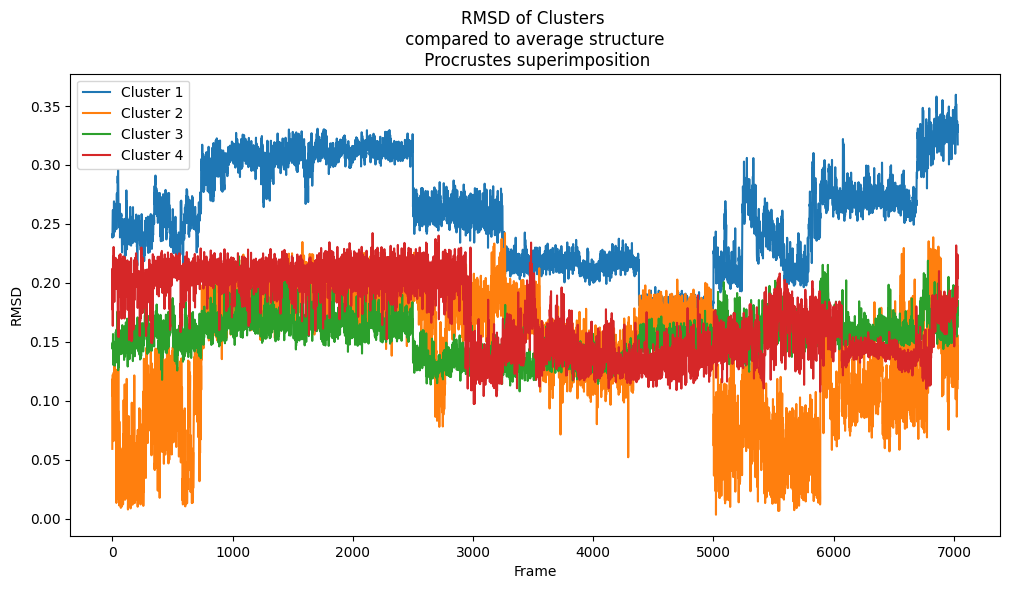

In [54]:
timestep_clusters, final_Qs = iterative_clustering_approach(traj_array, delta_matrices, Q_from_pos_trajectory_average_procrustes, compute_Q=True, k_cluster=k_cluster)